# Import Module

In [1]:
# !pip install nltk
# !pip install textblob 
# !pip install tweepy
# !pip install re

In [2]:
import pandas as pd 
import numpy as np

#Authentication module. for documentation  (http://docs.tweepy.org)
import tweepy as tp

#import nltk module 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#import reguler expression 
import re

#import textblob 
from textblob import TextBlob

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**SOURCE** :  [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python)

# SECTION A : Data Preparation

## Step A.1. Getting the authentication credentials

In [3]:
# initialize api instance
consumer_key = 'bySJcQnmkOpXvMsekbbTWgbcd'
consumer_secret = 'mlcy6AKUGHaMHhdxMWSuQkPtuEvR8ELQGzepMr0nlzzJWVPAHA'
access_token = '82082835-F0mFwiK4J4jDhSLsf3x4fb0UMuGxPxG7z4nbsRdOS'
access_token_secret = '7N1prAd6mRsnTFkZfr0WyOx0sFqSbqyi9JBFqRJj1SWph'

#Authentication
auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tp.API(auth)

## Step A.2. Getting a Dataset from twitter

In [146]:
#get tweet 
tweets = tp.Cursor(api.search,q=["#iphone11",],lang="en").items(500)
result = []
for tweet in  tweets :
    result.append(tweet)

## Step A.3 Extract Tweet to pandas dataframe

In [147]:
# extract tweet to the pandas dataframe
def tweets_df(results):
    id_list = [tweet.id for tweet  in results]
    df = pd.DataFrame(id_list, columns = ["id"])
    
    df["text"] = [tweet.text for tweet in results]
    df["created_at"] = [tweet.created_at for tweet in results]
    df["retweet_count"] = [tweet.retweet_count for tweet in results]
    df["user_screen_name"] = [tweet.author.screen_name for tweet in results]
    df["user_followers_count"] = [tweet.author.followers_count for tweet in results]
    df["user_location"] = [tweet.author.location for tweet in results]
    df["Hashtags"] = [tweet.entities.get('hashtags') for tweet in results]

    return df

In [148]:
# use the function to get dataframe of the tweet
df = tweets_df(result)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
id                      500 non-null int64
text                    500 non-null object
created_at              500 non-null datetime64[ns]
retweet_count           500 non-null int64
user_screen_name        500 non-null object
user_followers_count    500 non-null int64
user_location           500 non-null object
Hashtags                500 non-null object
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 31.3+ KB


In [149]:
#drop duplicate tweet 
g_unique = set()
for item in df['text']:
        g_unique.add(item) # ensures the element will only be copied if not already in the set
tweet = []
for item in g_unique:
    tweet.append(item)
    dataframe = pd.DataFrame(tweet,columns = ['text'])

In [150]:
len(dataframe)

370

# Section B : Data Preprocessing

## Step B.1. Basic Text Pre-processing 

### 1. Lower casing

In [151]:
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dataframe['text'].head()

0    rt @iamdabm: i dont understand policy of @appl...
1    analyzing #apple $aapl q4 2019 #earnings resul...
2    rt @ewan: the iterative approach to the #iphon...
3    rt @studiovickn: 🖤 10% off everything in my @t...
4    rt @techinrl: can’t rename your airpods or acc...
Name: text, dtype: object

### 2. Punctuation removal

In [152]:
# pat1 = r'@[A-Za-z0-9_]+'
# pat2 = r'https?://[^ ]+'
# combined_pat = r'|'.join((pat1, pat2))
# dataframe['text'] = dataframe['text'].str.replace(combined_pat,'')
dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
dataframe.head()

,text
0,rt iamdabm i dont understand policy of apple a...
1,analyzing apple aapl q4 2019 earnings results ...
2,rt ewan the iterative approach to the iphone11...
3,rt studiovickn 10 off everything in my thread...
4,rt techinrl cant rename your airpods or access...


### 3. Stopwords removal

In [153]:
stop = stopwords.words('english')
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dataframe['text'].head(10)

0    rt iamdabm dont understand policy apple us dif...
1    analyzing apple aapl q4 2019 earnings results ...
2    rt ewan iterative approach iphone11 seen apple...
3    rt studiovickn 10 everything threadless shop t...
4    rt techinrl cant rename airpods access airpods...
5    letstrackltd phir hera pheri contestalert ipho...
6    rt argentarts birth venus sandro botticelli ca...
7    rt yrfan2 iphone 11 besure latest update 132 l...
8    rt mkuldeep666 letstrackltd upon time mumbai c...
9    rt macrumors know iphone11 11 pro get wider se...
Name: text, dtype: object

### 4. Frequent words removal

In [154]:
freq = pd.Series(' '.join(dataframe['text']).split()).value_counts()[:10]
freq

iphone11        206
iphone          185
11              113
rt               87
apple            78
pro              70
new              57
letstrackltd     42
case             40
amp              36
dtype: int64

In [155]:
freq = list(freq.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0    iamdabm dont understand policy us difference 1...
1    analyzing aapl q4 2019 earnings results 4 char...
2    ewan iterative approach seen fall behind andro...
3    studiovickn 10 everything threadless shop toda...
4    techinrl cant rename airpods access airpods me...
Name: text, dtype: object

### 5. Rare words removal

In [156]:
rare_word = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-10:]
rare_word

bare                     1
email                    1
httpstcoxwih5rhthj       1
adjusting                1
lg                       1
li                       1
letstrackbollywoodish    1
httpstcogoc              1
wore                     1
httpstco73brbfl34i       1
dtype: int64

In [157]:
rare_word = list(rare_word.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0    iamdabm dont understand policy us difference 1...
1    analyzing aapl q4 2019 earnings results 4 char...
2    ewan iterative approach seen fall behind andro...
3    studiovickn 10 everything threadless shop toda...
4    techinrl cant rename airpods access airpods me...
Name: text, dtype: object

### 6. Spelling correction

In [158]:
dataframe['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    iamdabm dont understand policy us difference 1...
1    analyzing all qu 2019 earnings results 4 chart...
2    swan operative approach seen fall behind andro...
3    studiovickn 10 everything threadless shop toda...
4    techinrl can renamed airport access airport me...
Name: text, dtype: object

### 7. Tokenization

In [21]:
#!python -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\gilang.mahardika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zi

In [159]:
TextBlob(dataframe['text'][1]).words

WordList(['analyzing', 'aapl', 'q4', '2019', 'earnings', 'results', '4', 'charts', 'applenews', 'iphone11promax', 'applestock', 'httpstcoduzbcocb5t'])

### 8. Stemming

In [160]:
st = PorterStemmer()
dataframe['text'] = dataframe['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [161]:
dataframe.head()

,text
0,iamdabm dont understand polici us differ 100 i...
1,analyz aapl q4 2019 earn result 4 chart applen...
2,ewan iter approach seen fall behind android sm...
3,studiovickn 10 everyth threadless shop today c...
4,techinrl cant renam airpod access airpod menus...


### 9. Lematization

In [162]:
from textblob import Word
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
dataframe['text'].head()

0    iamdabm dont understand polici u differ 100 in...
1    analyz aapl q4 2019 earn result 4 chart applen...
2    ewan iter approach seen fall behind android sm...
3    studiovickn 10 everyth threadless shop today c...
4    techinrl cant renam airpod access airpod menus...
Name: text, dtype: object

In [163]:
dataframe.head()

,text
0,iamdabm dont understand polici u differ 100 in...
1,analyz aapl q4 2019 earn result 4 chart applen...
2,ewan iter approach seen fall behind android sm...
3,studiovickn 10 everyth threadless shop today c...
4,techinrl cant renam airpod access airpod menus...


# SECTION C : Data Exploration

## Step C.1. Basic feature extraction 

### 1. Number of words

In [164]:
dataframe['word_count'] = dataframe['text'].apply(lambda x: len(str(x).split(" ")))
dataframe.head()

,text,word_count
0,iamdabm dont understand polici u differ 100 in...,14
1,analyz aapl q4 2019 earn result 4 chart applen...,12
2,ewan iter approach seen fall behind android sm...,11
3,studiovickn 10 everyth threadless shop today c...,14
4,techinrl cant renam airpod access airpod menus...,12


### 2. Number of characters

In [165]:
dataframe['char_count'] = dataframe['text'].str.len()
dataframe.head()

,text,word_count,char_count
0,iamdabm dont understand polici u differ 100 in...,14,79
1,analyz aapl q4 2019 earn result 4 chart applen...,12,93
2,ewan iter approach seen fall behind android sm...,11,67
3,studiovickn 10 everyth threadless shop today c...,14,106
4,techinrl cant renam airpod access airpod menus...,12,88


### 3. Number of stopwords

In [166]:
stop = stopwords.words('english')
dataframe['stopwords'] = dataframe['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
dataframe.head()

,text,word_count,char_count,stopwords
0,iamdabm dont understand polici u differ 100 in...,14,79,0
1,analyz aapl q4 2019 earn result 4 chart applen...,12,93,0
2,ewan iter approach seen fall behind android sm...,11,67,0
3,studiovickn 10 everyth threadless shop today c...,14,106,0
4,techinrl cant renam airpod access airpod menus...,12,88,0


### 3. Number of special characters

In [167]:
dataframe['hastags'] = dataframe['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
dataframe.head()

,text,word_count,char_count,stopwords,hastags
0,iamdabm dont understand polici u differ 100 in...,14,79,0,0
1,analyz aapl q4 2019 earn result 4 chart applen...,12,93,0,0
2,ewan iter approach seen fall behind android sm...,11,67,0,0
3,studiovickn 10 everyth threadless shop today c...,14,106,0,0
4,techinrl cant renam airpod access airpod menus...,12,88,0,0


## Step C.2.  Labeling Using Polarity (Textblob)

### 1. New Dataframe

In [168]:
#new df after removed duplicate text
new_df = dataframe
new_df.head()

#sentiment labeling 
text = new_df.text

### 2. Labeling 

In [169]:
#looping 
for i in range(0,len(text)):
    textB = TextBlob(text[i])
    sentiment = textB.sentiment.polarity
    new_df.set_value(i,'sentiment', sentiment)
    if sentiment < 0.00 :
        sentimentclass = 'Negative'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    elif sentiment > 0.00 :
        sentimentclass = 'Positive'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    else :
        sentimentclass = 'Netral'
        new_df.set_value(i, 'sentimentclass', sentimentclass)

In [170]:
new_df = new_df[['text','sentiment','sentimentclass']]

In [172]:
new_df.to_csv('iphone11_sentiment.csv')

### 3. Aggregation Sentimentclass

In [173]:
#count sentiment 
sentiment = new_df.groupby(['sentimentclass'])['sentimentclass'].count()

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['sentimentclass']
chart.drop(['sentimentclass'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,sentimentclass,tweet_count,percent
0,Negative,43,0.116216
1,Netral,216,0.583784
2,Positive,111,0.300000


### 4. Visualization 

#### 4.1. Barchart

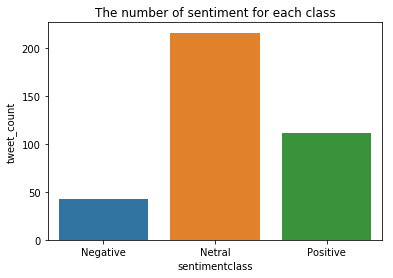

In [174]:
#make a barchar
ax = sns.barplot(x= 'sentimentclass', y='tweet_count', data=chart)
ax = ax.set_title('The number of sentiment for each class') 

#### 4.2. Pie Chart

(-1.106996059651552,
 1.1721290101989377,
 -1.313574394341532,
 1.1191501884205157)

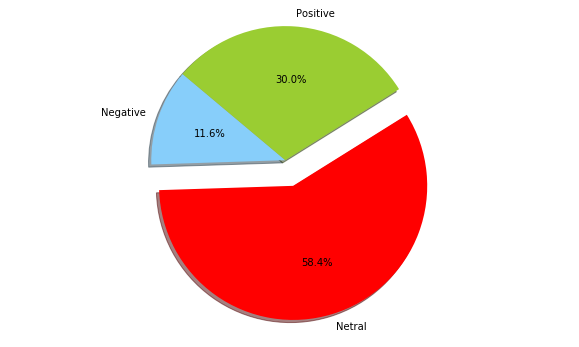

In [175]:
colors = [ 'lightskyblue','red','yellowgreen']
explode = (0, 0.2, 0)  # explode 1st slice
# Plot
figure = plt.figure(figsize= (10,6))
plt.pie(chart['tweet_count'], explode=explode, labels=chart['sentimentclass'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')